# Metehan Yıldırım

# Question 1a
We can show the decision area as  
\begin{equation} 
\begin{split}
 \mathbb{ \overline{C} } & = C_{00} P_0  \int_{z_0} p_{r|H_0}(R|H_0)dR \\
 & + C_{10} P_0  \int_{z_1} p_{r|H_0}(R|H_0)dR \\ 
 & + C_{11} P_1  \int_{z_1} p_{r|H_1}(R|H_1)dR \\
 & + C_{01} P_1  \int_{z_0} p_{r|H_1}(R|H_1)dR
\end{split}
\label{eq:eq1} \tag{1}
\end{equation}
and define false alarm, detection and miss probabilities as
\begin{equation}
    P_F = \int_{z_1}p_{r|H_0}(R|H_0)dR
\end{equation}
\begin{equation}
    P_D = \int_{z_1} p_{r|H_1}(R|H_1)dR
\end{equation}
\begin{equation}
    P_M = \int_{z_0} p_{r|H_1}(R|H_1)dR = 1 - P_D
\end{equation}
and
\begin{equation}
    Z = Z_0 + Z_1
\end{equation}
where $Z$ accounts for observation space. If we rewrite $\eqref{eq:eq1}$ as
\begin{equation} 
\begin{split}
 \mathbb{ \overline{C} } & = C_{00} P_0  \int_{z_0} p_{r|H_0}(R|H_0)dR \\
 & + C_{10} P_0  \int_{z - z_0} p_{r|H_0}(R|H_0)dR \\ 
 & + C_{11} P_1  \int_{z - z_0} p_{r|H_1}(R|H_1)dR \\
 & + C_{01} P_1  \int_{z_0} p_{r|H_1}(R|H_1)dR
\end{split}
\label{eq:eq2} \tag{2}
\end{equation}
with observing
\begin{equation}
    \int_{z} p_{r|H_0}(R|H_0)dR = \int_{z} p_{r|H_1}(R|H_1)dR = 1
\end{equation}
reducing $\eqref{eq:eq2}$ equation to
\begin{equation}
 \overline{C} = P_0 C_{00} (1-P_F)+P_0 C_{10}P_F + P_1C_{01}P_M + P_1 C_{11}(1 - P_M) 
\end{equation}
and using $P_0 = 1 - P_1$, we can write
\begin{equation}
\begin{split}
     \overline{C} = & C_{00} - C_{00}P_1 - C_{00}P_F + C_{00}P_1P_F + C_{10}P_F - C_{10}P_1P_F + C_{01}P_1P_M C_{11}P_1- C_{11}P_1P_M
\end{split}
\end{equation}
and if rearrange these quantities into $P_1$ parenthesis;
\begin{equation}
    \begin{split}
        \overline{C} = & C_{00}(1-P_F) + C_{10}P_F + P_1[(C_{11}-C_{00})+(C_{10}-C_{11}P_M)-(C_{10}-C_{00}P_F)].
    \end{split}
\end{equation}
Second part of question is asking a condition that maximize $\overline{C}$. Since $\overline{C}$ concave to $P_1$, we can write
\begin{equation}
      \frac{\partial \overline{C} }{\partial P_1} = 0
\end{equation}
and it simply gives
\begin{equation}
    (C_{11}-C_{00})+(C_{10}-C_{11}P_M)-(C_{10}-C_{00}P_F) = 0
\end{equation}
condition.

# Question 1b

In question, hypothesis are given as
\begin{equation}
    P_{r|H_0}(R|H_0)  \sim N(1,1)
\end{equation}
\begin{equation}
    P_{r|H_1}(R|H_1)  \sim N(-1,1).
\end{equation}
We derived minimax condition previous question, which is
\begin{equation}
    (C_{11}-C_{00})+(C_{10}-C_{11}P_M)-(C_{10}-C_{00}P_F) = 0.
\end{equation}
If we put given cost values into equation, we get
\begin{equation}
    6P_M = P_F.
\end{equation}
Thus, we need to decide the intervals of integrals that we stated previously that
\begin{equation}
    \int_{z_1}p_{r|H_0}(R|H_0)dR = 6\bigg[\int_{z_0} p_{r|H_1}(R|H_1)dR\bigg]
\end{equation}
and we are looking for a threshold $\xi$ separating $z$ region.If we denote the threshold $\xi$ between $z_0$ & $z_1$, equation becomes
\begin{equation}
     \bigg[1 - \int_{\xi}^\infty p_{r|H_0}(R|H_0)dR\bigg] = 6 \int_{\xi}^\infty p_{r|H_1}(R|H_1)dR.
\end{equation}
and it becomes
\begin{equation}
     1- \Phi\bigg(\frac{\xi - 1}{1}\bigg) = 6 \Phi\bigg(\frac{\xi +1}{1}\bigg).
\end{equation}
and it is numerical solved as $\xi = 0.58$. Under minimax rule, $\overline{C}$ becomes
\begin{equation}
\begin{split}
    \overline{C} & = P_F \\
    & =  \int_{-\infty}^\xi p_{r|H_0}(R|H_0)dR \\
    & = 1-\Phi(\xi-1) \\
    & = 0.33
\end{split}
\end{equation}
where $\xi = 0.58$.

# Question 2

In [197]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import scipy
%matplotlib inline


# # Question 2a-b: MAP Threshold of Individual Observations
$H_1: r = 1 + n$\
$H_0: r = n$\
where $n$ is additive Gaussian Noise with $R(\tau)=\sigma^2\delta(\tau)\tag{1}$ and $\sigma^2 = \frac{N_0}{2}$. MAP decision will be defined as 

\begin{equation*}
\frac{p_{r | H_1}(r | H_1)}{p_{r | H_0}(r | H_0)} \underset{H_0}{\overset{H_1}{\gtrless}} \frac{p(H_0)}{p(H_1)}
\end{equation*}

where 
\begin{equation*}
p_{r | H_1}(r | H_1)= {\frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}}e^{-{\frac {1}{2}}\left((r-1 )/\frac{N_0}{2} \right)^{2}}
\end{equation*}
\begin{equation*}
p_{r | H_0}(r | H_0)= {\frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}}e^{-{\frac {1}{2}}\left((r )/\frac{N_0}{2} \right)^{2}}
\end{equation*}
and $p(H_0) = 1/3$ and $p(H_1) = 2/3$ is given in question. If we define likelihood ratio and threshold as
\begin{equation*}
 \Lambda(r) = \frac{p_{r | H_1}(r | H_1)}{p_{r | H_0}(r | H_0)} \\
\end{equation*}
and
\begin{equation*}
\xi = \frac{p(H_0)}{p(H_1)} = 1/2
\end{equation*}



 and apply logaritmic transformation to make the division easy for exponentials, we get
\begin{equation*}
ln \Lambda(r) = \frac{2}{N_0}r - \frac{1}{N_0}
\end{equation*}
and threshold directly affecting observation (single observation) becomes
\begin{equation*}
r \underset{H_0}{\overset{H_1}{\gtrless}} \frac{N_0}{2} ln (\xi) + 1/2
\end{equation*}
and numerical threshold for each observation can be calculated and it depends AWGN on channel directly.

In [198]:
db_noise = [0,-2,-4,-6] #in dB

# Decision Rules with Given Noise
## Given assignment suggests that try out 3 things:
1 - AND Gate in k digits\
2 - OR Gate in k digits\
3 - Choose according to M-of-k digits

Actually, these suggestions are simply one rule with parameter M. If M = k, it is AND gate, if M = 1, it is OR gate. I wrote function that accepts M as a parameter as well. And tried it between 1 and k.
### Note: I use M-of-K rule with "equal and greater".

In [199]:
def uniform_cost_single_observation(noise): #N0_2 in linear 
    return noise * np.log(1/2) + 1/2
def db2linear(value):
    return 10 ** (value/10) 

In [200]:
def gate_decision(noise, M, threshold_func, k=10, sequence_length = 10000):
    error = 0
    count = 0
    while error < 300:
            #Threshold for given noise
        count += 1
        threshold = threshold_func(db2linear(noise))
            #Sequence generating
        random_sequence = torch.rand(1,sequence_length)[0]
        ones_zeros = (random_sequence > 1/3).float()
            #Repeating each bit k times
        ones_zeros_rep = ones_zeros.repeat(k, 1)
        noise_signal = torch.empty(k, sequence_length).normal_(mean=0,std=np.sqrt(db2linear(noise)))
        reciever = noise_signal + ones_zeros_rep
        sequence_recieved = torch.sum((reciever > threshold).float(),dim=0) >= M
        error += torch.sum(torch.abs(sequence_recieved.float() - ones_zeros))
#         print(f"error sayisi:{error}, count: {count}")
        

    bit_error_rate = error / (count * sequence_length)
    
    return bit_error_rate

In [201]:
db_noise

[0, -2, -4, -6]

In [202]:
BER = []
BER_m = []
for m in range(1,11):
    for noise in db_noise:
        BER.append(gate_decision(noise, M = m, threshold_func = uniform_cost_single_observation).data.numpy())
    BER_m.append(np.array(BER))
    BER = []
    

In [203]:
BER_m

[array([0.3246, 0.333 , 0.3377, 0.3151], dtype=float32),
 array([0.3321, 0.3369, 0.3071, 0.2569], dtype=float32),
 array([0.3339, 0.3075, 0.2585, 0.1632], dtype=float32),
 array([0.306 , 0.2546, 0.1799, 0.0863], dtype=float32),
 array([0.2687 , 0.1798 , 0.0896 , 0.02795], dtype=float32),
 array([0.1937  , 0.1034  , 0.0351  , 0.007725], dtype=float32),
 array([0.1206, 0.0584, 0.0228, 0.0072], dtype=float32),
 array([0.1043, 0.079 , 0.0588, 0.0387], dtype=float32),
 array([0.2174, 0.2236, 0.2059, 0.1464], dtype=float32),
 array([0.4662, 0.4764, 0.4611, 0.396 ], dtype=float32)]

### Since we ploted error vectors corresponds each M values with given noise levels.

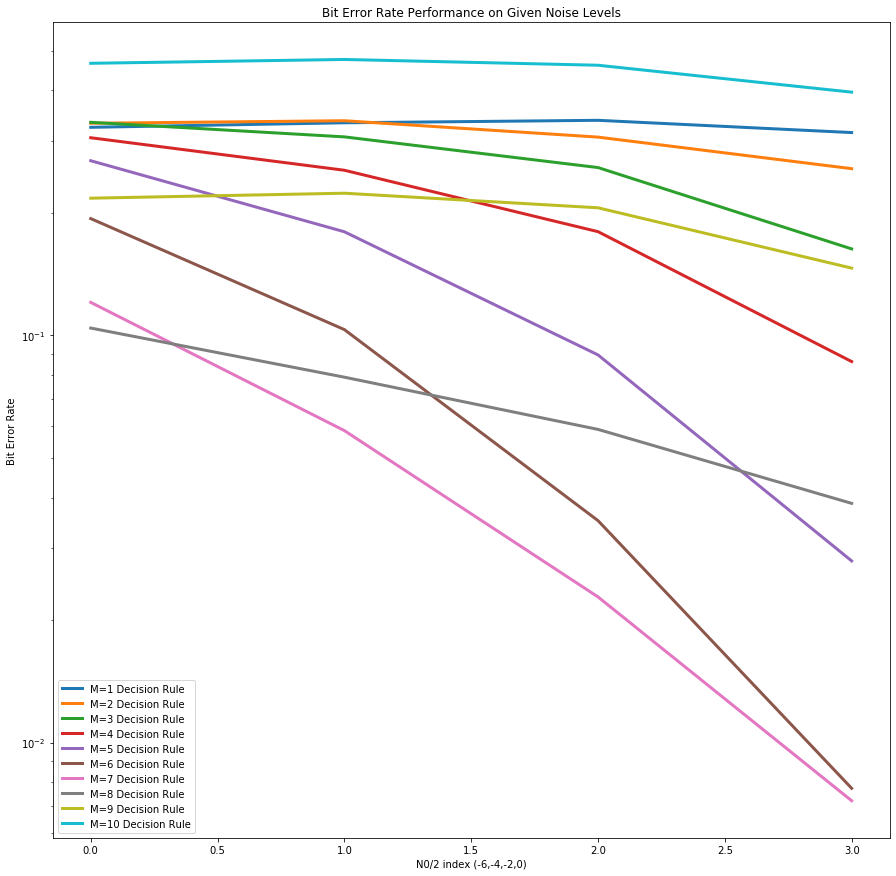

In [204]:
plt.figure(figsize=(15, 15))
plt.title("Bit Error Rate Performance on Given Noise Levels")
for i,errors in enumerate(BER_m):
    plt.plot(errors, lw=3, label=f"M={i+1} Decision Rule")
plt.yscale('log')
plt.xlabel("N0/2 index (-6,-4,-2,0)")
plt.ylabel("Bit Error Rate")
plt.legend()

#### M=7 outperforms single observation methods.

## # Question 2c-d MAP Threshold of K - Observations
$H_1: r_i = 1 + n$\
$H_0: r_i = n_i$\
where $n_i$ is additive Gaussian Noise with $R(\tau)=\sigma^2\delta(\tau)\tag{1}$ and $\sigma^2 = \frac{N_0}{2}$. MAP decision will be defined as 

\begin{equation*}
\frac{p_{r | H_1}(r | H_1)}{p_{r | H_0}(r | H_0)} \underset{H_0}{\overset{H_1}{\gtrless}} \frac{p(H_0)}{p(H_1)}
\end{equation*}

where 
\begin{equation*}
p_{r | H_1}(R | H_1)= \prod_{n=1}^N \frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}e^{-{\frac {1}{2}}\left((r_i-1 )/\frac{N_0}{2} \right)^{2}}\end{equation*}
\begin{equation*}
p_{r | H_0}(R | H_0)= \prod_{n=1}^N {\frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}}e^{-{\frac {1}{2}}\left((r_i )/\frac{N_0}{2} \right)^{2}}\end{equation*}
and $p(H_0) = 1/3$ and $p(H_1) = 2/3$ is given in question. If we define likelihood ratio and threshold as
\begin{equation*}
 \Lambda(R) = \frac{p_{r | H_1}(R | H_1)}{p_{r | H_0}(R | H_0)} \\
\end{equation*}
and
\begin{equation*}
\xi = \frac{p(H_0)}{p(H_1)} = 1/2.
\end{equation*}
To calculate $\Lambda(R)$, we cancel common terms and taking logirithm, then we have
\begin{equation*}
ln \Lambda(R) = \frac{2}{N_0} \sum_{i=1}^N r_i - \frac{N*N_0}{2}
\end{equation*}
and threshold directly affecting observationS (N=10 observation) becomes
\begin{equation*}
\sum_{i=1}^N r_i \underset{H_0}{\overset{H_1}{\gtrless}} \frac{N_0}{2} ln (\xi) + \frac{N*N_0}{2}
\end{equation*}
and numerical threshold for each observation can be calculated and it depends AWGN on channel directly.

In [205]:
def k_observation(noise): #N0_2 in linear 
    return noise * np.log(1/2) + 5 #k = 10

In [206]:
def gate_decision_k_observation(noise, threshold_func, k=10, sequence_length = 10000):
    error = 0
    count = 0
    while error < 300:
            #Threshold for given noise
        count += 1
        threshold = threshold_func(db2linear(noise))
            #Sequence generating
        random_sequence = torch.rand(1,sequence_length)[0]
        ones_zeros = (random_sequence > 1/3).float()
            #Repeating each bit k times
        ones_zeros_rep = ones_zeros.repeat(k, 1)
        noise_signal = torch.empty(k, sequence_length).normal_(mean=0,std=np.sqrt(db2linear(noise)))
        reciever = noise_signal + ones_zeros_rep
        sequence_recieved = torch.sum(reciever,dim=0) >= threshold
        error += torch.sum(torch.abs(sequence_recieved.float() - ones_zeros))
#         print(f"error sayisi:{error}, count: {count}")
        

    bit_error_rate = error / (count * sequence_length)
    
    return bit_error_rate

In [207]:
BER = []
for noise in db_noise:
    BER.append(gate_decision_k_observation(noise, threshold_func = k_observation).data.numpy())
BER

[array(0.0554, dtype=float32),
 array(0.02045, dtype=float32),
 array(0.0061, dtype=float32),
 array(0.00084444, dtype=float32)]

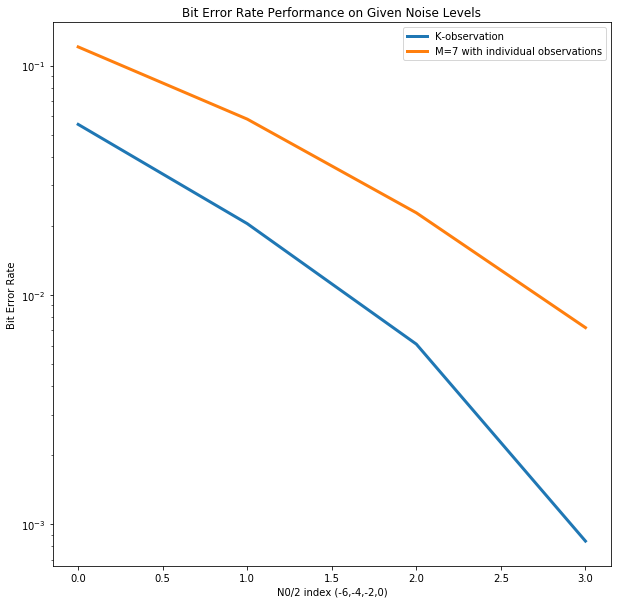

In [208]:
plt.figure(figsize=(10, 10))
plt.title("Bit Error Rate Performance on Given Noise Levels")
plt.plot(BER, lw=3, label=f"K-observation")
plt.plot(BER_m[6], lw=3, label=f"M=7 with individual observations")
plt.yscale('log')
plt.xlabel("N0/2 index (-6,-4,-2,0)")
plt.ylabel("Bit Error Rate")
plt.legend()

#### K-observation outperforms single observation methods.

## # Question 2e MAP Threshold with Different Costs
Changing costs only affects $\xi$ value since

\begin{equation*}
\xi = \frac{p(H_0)(C_{10}-C_{00})}{p(H_1)(C_{01}-C_{11})} = 1.5
\end{equation*}

In [209]:
def constant_cost_single_observation(noise): #N0_2 in linear 
    return noise * np.log(3/2) + 1/2

In [210]:
def constant_cost_k_observation(noise): #N0_2 in linear 
    return noise * np.log(3/2) + 5 #k = 10

In [211]:
BER = []
BER_m_costs = []
for m in range(1,11):
    for noise in db_noise:
        BER.append(gate_decision(noise, M = m, threshold_func = constant_cost_single_observation).data.numpy())
    BER_m_costs.append(np.array(BER))
    BER = []

In [212]:
BER_costs = []
for noise in db_noise:
    BER_costs.append(gate_decision_k_observation(noise,threshold_func = constant_cost_k_observation).data.numpy())
BER_costs

[array(0.063, dtype=float32),
 array(0.02585, dtype=float32),
 array(0.00676, dtype=float32),
 array(0.00085278, dtype=float32)]

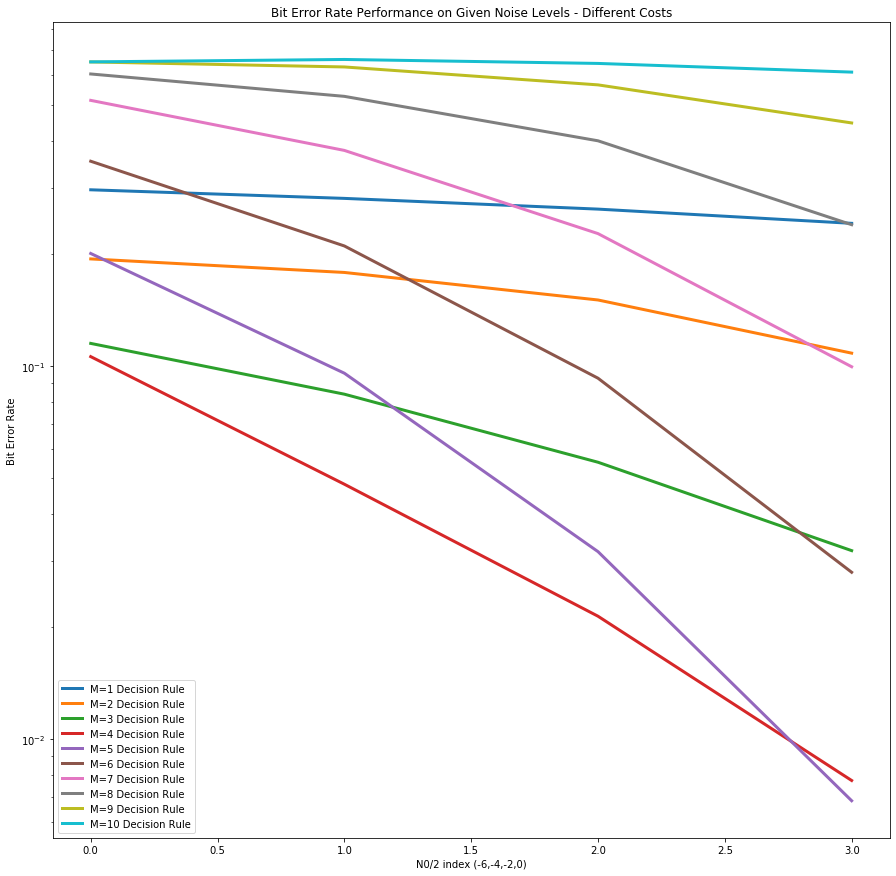

In [213]:
plt.figure(figsize=(15, 15))
plt.title("Bit Error Rate Performance on Given Noise Levels - Different Costs")
for i,errors in enumerate(BER_m_costs):
    plt.plot(errors, lw=3, label=f"M={i+1} Decision Rule")
plt.yscale('log')
plt.xlabel("N0/2 index (-6,-4,-2,0)")
plt.ylabel("Bit Error Rate")
plt.legend()

#### M=4 outperforms single observation methods.

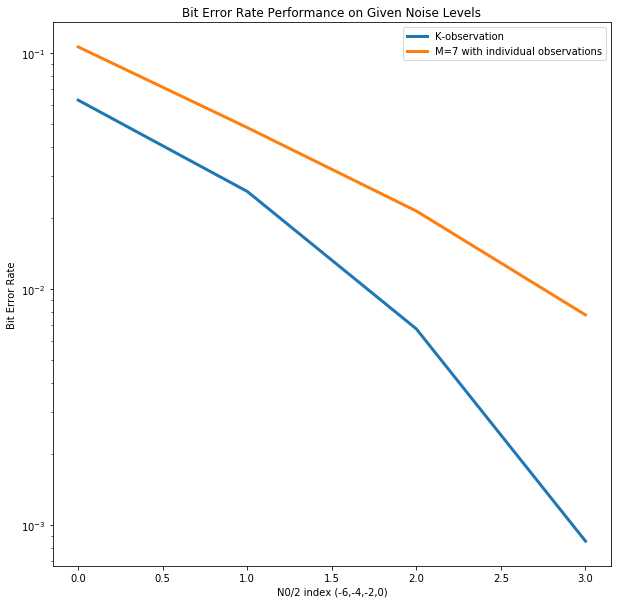

In [214]:
plt.figure(figsize=(10, 10))
plt.title("Bit Error Rate Performance on Given Noise Levels")
plt.plot(BER_costs, lw=3, label=f"K-observation")
plt.plot(BER_m_costs[3], lw=3, label=f"M=7 with individual observations")
plt.yscale('log')
plt.xlabel("N0/2 index (-6,-4,-2,0)")
plt.ylabel("Bit Error Rate")
plt.legend()

# Finally, we receive best results with given cost values and k-observation methods.